In [1]:
import numpy as np
import scipy.io
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
%matplotlib qt

In [2]:
def n_complex_synthetic(omega):
    #takes in a list and returns a list of complex numbers
    ret = np.empty(len(omega),dtype=complex)
    for i in np.arange(len(omega)):
        real = n0**2+np.sum(B_j*(omega_j**2-omega[i]**2)/((omega_j**2-omega[i]**2)**2+gamma_j**2*omega[i]**2))
        imag =  np.sum((B_j*gamma_j*omega[i])/((omega_j**2-omega[i]**2)**2+gamma_j**2*omega[i]**2))
        ret[i] = np.sqrt(real + 1j*imag)
    return ret 


def A_L():
    #takes in floats and returns a float
    r = r_data[:p]
    omega = omega_data[:p]
    n_omega_j = (r+1)/(1-r)
    return (1/p)*np.sum((n_omega_j**2 - n_L**2)*(omega_OL**2-omega**2))
    
def n_complex_L(w):
    #takes in a list of omega and returns a list of complex numbers
    ret = np.empty(len(w),dtype=complex)
    for i in np.arange(len(ret)):
        ret[i] = np.sqrt(n_L**2+A_L()/(omega_OL**2-w[i]**2))
    return ret

def A_U():
    #takes in floats and returns a float
    r = r_data[-h:]
    omega = omega_data[-h:]
    n_omega_j = (r+1)/(1-r)
    return (1/h)*np.sum((n_omega_j**2 - n_U**2)*(omega_OU**2-omega**2))

def n_complex_U(w):
    #takes in a list of omega and returns a list of complex numbers
    ret = np.empty(len(w),dtype=complex)
    for i in np.arange(len(ret)):
        ret[i] = np.sqrt(n_U**2+A_U()/(omega_OU**2-w[i]**2))
    return ret

def reconstruct_wings(w):
    #takes in a list of omega and returns a list of real numbers
    ret = np.empty(len(w),dtype=complex)
    #Do L side
    n_comp = n_complex_L(w[:omega_L_index])
    ret[:omega_L_index] = np.abs(n_comp-1)/(n_comp+1)
    #Do middle
    ret[omega_L_index:omega_U_index+1] = r_data
    #Do U side
    n_comp = n_complex_U(w[omega_U_index+1:])
    ret[omega_U_index+1:] = np.abs(n_comp-1)/(n_comp+1)
    return ret

def theta(omega_i):
    omega_i_index = np.argmax(omega_reconstruct>=omega_i)    
    np.seterr(divide='ignore', invalid='ignore')
    integrand = (2*omega_i/np.pi)*(np.log(r_reconstruct)-np.log(r_reconstruct[omega_i_index]))/(omega_i**2-omega_reconstruct**2)
    #fix up divide by zero with limiting value if in range:
    if omega_i_index < len(omega_reconstruct)-1:
        integrand[omega_i_index] = (2*omega_i/np.pi)*(np.log(r_reconstruct[omega_i_index+1])-np.log(r_reconstruct[omega_i_index-1]))/((omega_i-1)**2-(omega_i+1)**2)
    ret = integrate.simps(integrand[1:-1],omega_reconstruct[1:-1])
    #add correction for integrating to zero
    ret = ret - (1/np.pi)*(np.log(r_reconstruct[0])-np.log(r_reconstruct[omega_i_index]))*(np.log((omega_i-omega_low_reconstruct)/(omega_i+omega_low_reconstruct)))
    #add correction for integrating to infty
    ret = ret + (1/np.pi)*(np.log(r_reconstruct[-1])-np.log(r_reconstruct[omega_i_index]))*(np.log((omega_high_reconstruct-omega_i)/(omega_high_reconstruct+omega_i)))
    return ret

#Define the synthetic spectrum's resonances
omega_j = np.array([400,550,600,720])
B_j = np.array([10000,50000,30000,4000])
gamma_j = np.array([8,10,12,20])
n0 = 1.50

omega_L = 500.0
omega_U = 700.0

omega = np.linspace(omega_L,omega_U,2001)
n_synthetic = n_complex_synthetic(omega) 
r_data = np.abs((n_synthetic-1)/(n_synthetic+1)) #this is what is measured in experiment

with open('synthetic_data.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for i in np.arange(len(r_data)):
        writer.writerow([omega[i],r_data[i]])    
        
omega_L = 0.0
omega_U = 1000.0

omega_full = np.linspace(omega_L,omega_U,10001)
n_synthetic_full = n_complex_synthetic(omega_full) 
r_data_full = np.abs((n_synthetic_full-1)/(n_synthetic_full+1)) #this is what is measured in experiment

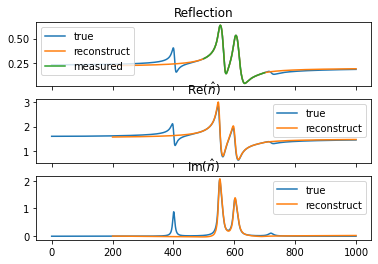

In [3]:
with open('synthetic_data.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    omega_data = np.array([])
    r_data = np.array([])    
    for row in reader: 
        omega_data = np.append(omega_data,float(row[0]))
        r_data = np.append(r_data,float(row[1]))
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)
        
# # define "Imported" data
omega_low_reconstruct = 200
omega_high_reconstruct = 1000
omega_reconstruct = np.arange(omega_low_reconstruct,omega_high_reconstruct+d_omega,d_omega)
omega_L_index = np.argmax(omega_reconstruct>=omega_data[0])
omega_U_index = np.argmax(omega_reconstruct>=omega_data[-1])

n_L = 1.5
omega_OL = 550
p = 1
n_U = 1.5
omega_OU = 600
h = 1

r_reconstruct = np.real(reconstruct_wings(omega_reconstruct))

theta_reconstruct = np.empty(len(omega_reconstruct))
for i in np.arange(len(theta_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
# plt.plot(omega_reconstruct,n)
# plt.plot(omega[omega_L_index:omega_U_index+1],np.real(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))
# plt.plot(omega_reconstruct,k)
# plt.plot(omega[omega_L_index:omega_U_index+1],np.imag(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

plt.show()

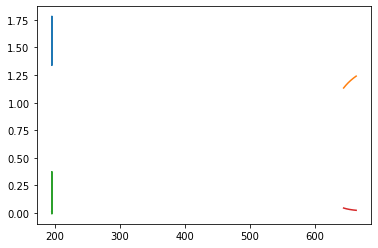

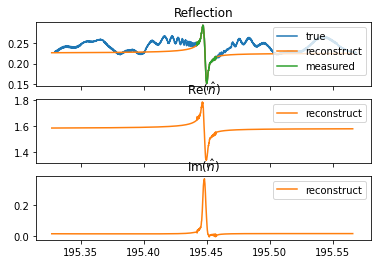

In [25]:
with open('test.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    omega_data = np.array([])
    r_data = np.array([])    
    for row in reader: 
        omega_data = np.append(omega_data,float(row[0]))
        r_data = np.append(r_data,float(row[1]))
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

r_data_full = r_data[49500:52500]*0.31
omega_full = omega_data[49500:52500]

# plt.plot(omega_data,t_data)
# plt.plot(omega_data,r_data)
# plt.show()

r_data = r_data[50916:51110]
omega_data = omega_data[50916:51110]
        
# # define "Imported" data
omega_low_reconstruct = 195.32689946
omega_high_reconstruct = 195.56600681


omega_reconstruct = np.arange(omega_low_reconstruct,omega_high_reconstruct+d_omega,d_omega)

omega_L_index = np.argmax(omega_reconstruct>=omega_data[0])
omega_U_index = np.argmax(omega_reconstruct>=omega_data[-1])

n_L = 1.58
omega_OL = 195.449
p = 1
n_U = 1.58
omega_OU = 195.449
h = 1
r_data = r_data*0.31
r_reconstruct = np.real(reconstruct_wings(omega_reconstruct))

theta_reconstruct = np.empty(len(omega_reconstruct))
for i in np.arange(len(theta_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
plt.plot(omega_reconstruct,n)
plt.plot(omega[omega_L_index:omega_U_index+1],np.real(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))
plt.plot(omega_reconstruct,k)
plt.plot(omega[omega_L_index:omega_U_index+1],np.imag(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
# axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
# axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

# plt.show()

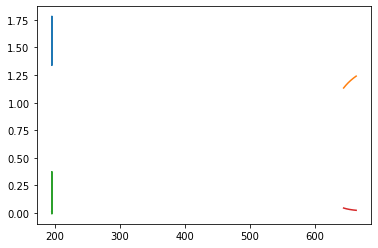

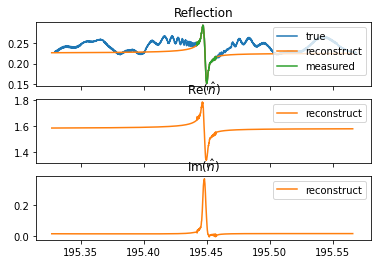

In [27]:
with open('test.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    omega_data = np.array([])
    r_data = np.array([])    
    for row in reader: 
        omega_data = np.append(omega_data,float(row[0]))
        r_data = np.append(r_data,float(row[1]))
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

r_data_full = r_data[49500:52500]*0.31
omega_full = omega_data[49500:52500]

# plt.plot(omega_data,t_data)r
# plt.plot(omega_data,r_data)
# plt.show()

r_data = r_data[50916:51110]
omega_data = omega_data[50916:51110]
        
# # define "Imported" data
omega_low_reconstruct = 195.32689946
omega_high_reconstruct = 195.56600681


omega_reconstruct = np.arange(omega_low_reconstruct,omega_high_reconstruct+d_omega,d_omega)

omega_L_index = np.argmax(omega_reconstruct>=omega_data[0])
omega_U_index = np.argmax(omega_reconstruct>=omega_data[-1])

n_L = 1.58
omega_OL = 195.449
p = 1
n_U = 1.58
omega_OU = 195.449
h = 1
r_data = r_data*0.31
r_reconstruct = np.real(reconstruct_wings(omega_reconstruct))

theta_reconstruct = np.empty(len(omega_reconstruct))
for i in np.arange(len(theta_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
plt.plot(omega_reconstruct,n)
plt.plot(omega[omega_L_index:omega_U_index+1],np.real(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))
plt.plot(omega_reconstruct,k)
plt.plot(omega[omega_L_index:omega_U_index+1],np.imag(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
# axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
# axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

# plt.show()

In [24]:
with open('model.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    omega_data = np.array([])
    r_data = np.array([])    
    for row in reader: 
        omega_data = np.append(omega_data,float(row[0]))
        r_data = np.append(r_data,float(row[1]))
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

# # define "Imported" data
omega_low_reconstruct = 195.32689946
omega_high_reconstruct = 195.56600681


omega_reconstruct = np.arange(omega_low_reconstruct,omega_high_reconstruct+d_omega,d_omega)

omega_L_index = np.argmax(omega_reconstruct>=omega_data[0])
omega_U_index = np.argmax(omega_reconstruct>=omega_data[-1])

n_L = 1.58
omega_OL = 195.449
p = 1
n_U = 1.58
omega_OU = 195.449
h = 1
r_data = r_data*0.31
r_reconstruct = np.real(reconstruct_wings(omega_reconstruct))

theta_reconstruct = np.empty(len(omega_reconstruct))
for i in np.arange(len(theta_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
# plt.plot(omega_reconstruct,n)
# plt.plot(omega[omega_L_index:omega_U_index+1],np.real(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))
# plt.plot(omega_reconstruct,k)
# plt.plot(omega[omega_L_index:omega_U_index+1],np.imag(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))

# f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'rough model', color='C3')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
axarr[1].plot(omega_reconstruct, n, label = 'rough model', color='C3')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
axarr[2].plot(omega_reconstruct, k, label = 'rough model', color='C3')
axarr[2].legend()

plt.show()

Analyse pretty looking data for Rose's grant

In [3]:
import scipy.io
n1 = 1
n2 = 1.57
data = scipy.io.loadmat('04Oct2018_2_74.mat')

In [12]:
np.mean(data['frequency'][0][14120:14520])

195.43195000004755

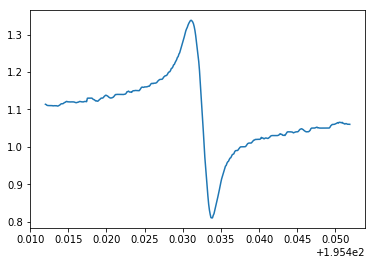

In [4]:
plt.plot(data['frequency'][0][14120:14520],data['reflection'][0][14120:14520])

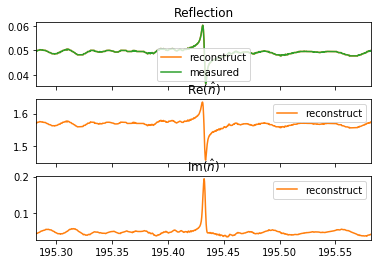

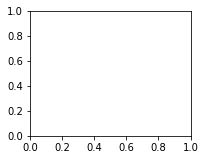

In [5]:
import scipy.io
n1 = 1
n2 = 1.57
data = scipy.io.loadmat('04Oct2018_2_74.mat')
r_data = np.sqrt(data['reflection'][0][14320-2000:14320+2000])
r_data = r_data/np.nanmean(r_data)*((n2-n1)/(n2+n1))
omega_data = data['frequency'][0][14320-2000:14320+2000]
        
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

omega_reconstruct = omega_data
omega_L_index = 0
omega_U_index = len(omega_reconstruct)-1

omega_low_reconstruct = omega_reconstruct[omega_L_index]
omega_high_reconstruct = omega_reconstruct[omega_U_index]

r_reconstruct = r_data
theta_reconstruct = np.empty(len(omega_reconstruct))

for i in np.arange(len(omega_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
# axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct**2, label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data**2 , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
# axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
# axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

plt.xlim(195.432-0.15,195.432+0.15)

fig,ax = plt.subplots(figsize=(2.5*1.15,2*1.15))
df = 20
f0 = 195.432

In [ ]:
c=3e8
plt.plot((omega_data-f0)*1000,2*k*(omega_data*1e12*2*np.pi)/c/100)
plt.xlim(-df,df)
plt.ylabel("cm^-1")

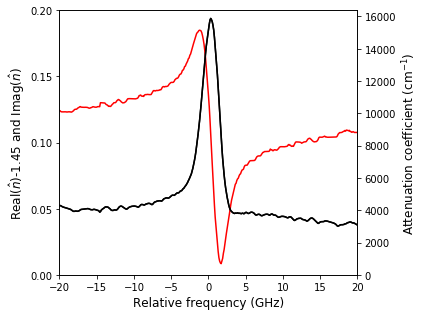

In [6]:
fig,ax = plt.subplots(figsize=(6,4.5))
ax2 = ax.twinx()
df = 20
f0 = 195.432
c = 3e8
refl_scaled = data['reflection'][0]/np.nanmean(data['reflection'][0])*((n1-n2)/(n1+n2))**2
alpha = 2*k*(omega_data*1e12*2*np.pi)/c/100

ax.plot((omega_data-f0)*1000, n-1.45,c='r')
ax.plot((omega_data-f0)*1000, k,c='k')
ax.set_ylim(0,0.20)
ax.set_xlim(-df,df)
ax.set_ylabel("Real($\hat{n}$)-1.45 and Imag($\hat{n}$)",fontsize=12)
ax.set_yticks([0,0.05,0.10,0.15,0.20])
ax.set_xlabel("Relative frequency (GHz)",fontsize=12)

ax2.plot((omega_data-f0)*1000,alpha,c='k')
ax2.set_ylim(0,0.20/np.nanmax(k)*np.nanmax(alpha))
ax2.set_ylabel("Attenuation coefficient (cm${}^{-1}$)",fontsize=12)
plt.tight_layout()
plt.savefig("temp2.svg")


Text(0, 0.5, 'cm^-1')

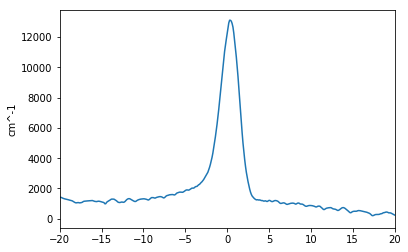

In [ ]:
#working out what causes a constant offset in absorption

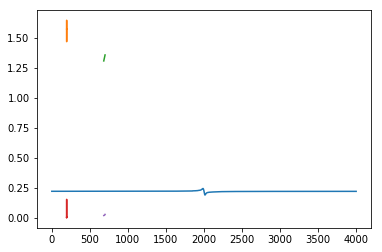

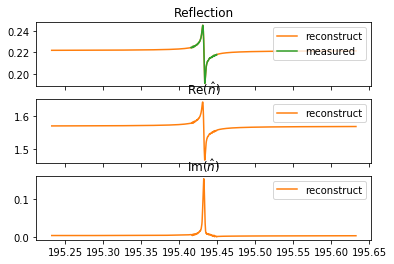

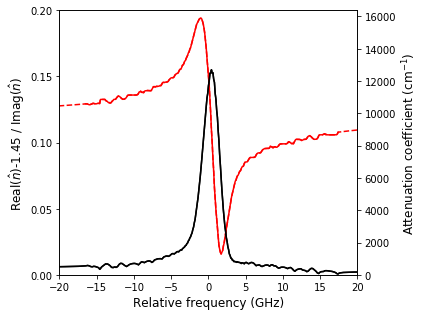

In [21]:
import scipy.io
n1 = 1
n2 = 1.57
data = scipy.io.loadmat('04Oct2018_2_74.mat')
r_data = np.sqrt(data['reflection'][0][14325-2000:14325+2000])
r_data = r_data/np.nanmean(r_data)*((n2-n1)/(n2+n1))
omega_data = data['frequency'][0][14325-2000:14325+2000]

d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

start = 1830
stop = 2170
r_data = r_data[start:stop]
omega_data = omega_data[start:stop]

# # define "Imported" data
omega_low_reconstruct = data['frequency'][0][14325-2000]
omega_high_reconstruct = data['frequency'][0][14325+2000]


omega_reconstruct = np.arange(omega_low_reconstruct,omega_high_reconstruct+d_omega,d_omega)

omega_L_index = np.argmax(omega_reconstruct>=omega_data[0])
omega_U_index = np.argmax(omega_reconstruct>=omega_data[-1])

n_L = 1.57
omega_OL = 195.433
p = 1
n_U = 1.57
omega_OU = 195.433
h = 1
r_data = r_data
r_reconstruct = np.real(reconstruct_wings(omega_reconstruct))
plt.plot(r_reconstruct)
theta_reconstruct = np.empty(len(omega_reconstruct))
for i in np.arange(len(theta_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
plt.plot(omega_reconstruct,n)
plt.plot(omega[omega_L_index:omega_U_index+1],np.real(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))
plt.plot(omega_reconstruct,k)
plt.plot(omega[omega_L_index:omega_U_index+1],np.imag(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
# axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
# axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
# axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

# plt.show()

fig,ax = plt.subplots(figsize=(6,4.5))
ax2 = ax.twinx()
df = 20
f0 = 195.432
c = 3e8
alpha = 2*k*(omega_reconstruct*1e12*2*np.pi)/c/100

ax.plot((omega_reconstruct-f0)*1000, n-1.45,'r--')
ax.plot((omega_reconstruct[start:stop]-f0)*1000, n[start:stop]-1.45,'r')
ax.plot((omega_reconstruct-f0)*1000, k,c='k')
ax.set_ylim(0,0.20)
ax.set_xlim(-df,df)
ax.set_ylabel("Real($\hat{n}$)-1.45 / Imag($\hat{n}$)",fontsize=12)
ax.set_yticks([0,0.05,0.10,0.15,0.20])
ax.set_xlabel("Relative frequency (GHz)",fontsize=12)

ax2.plot((omega_reconstruct-f0)*1000,alpha,c='k')
ax2.set_ylim(0,0.20/np.nanmax(k)*np.nanmax(alpha))
ax2.set_ylabel("Attenuation coefficient (cm${}^{-1}$)",fontsize=12)
plt.tight_layout()
plt.savefig("temp2.svg")


In [96]:
with open('test.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    omega_data = np.array([])
    r_data = np.array([])    
    for row in reader: 
        omega_data = np.append(omega_data,float(row[0]))
        r_data = np.append(r_data,float(row[1]))
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

r_data_full = r_data[49500:52500]*0.31
omega_full = omega_data[49500:52500]

# plt.plot(omega_data,t_data)
# plt.plot(omega_data,r_data)
# plt.show()

r_data = r_data[50916:51110]
omega_data = omega_data[50916:51110]
        
# # define "Imported" data
omega_low_reconstruct = 195.32689946
omega_high_reconstruct = 195.56600681


omega_reconstruct = np.arange(omega_low_reconstruct,omega_high_reconstruct+d_omega,d_omega)

omega_L_index = np.argmax(omega_reconstruct>=omega_data[0])
omega_U_index = np.argmax(omega_reconstruct>=omega_data[-1])

n_L = 1.58
omega_OL = 195.449
p = 1
n_U = 1.58
omega_OU = 195.449
h = 1
r_data = r_data*0.31
r_reconstruct = np.real(reconstruct_wings(omega_reconstruct))

theta_reconstruct = np.empty(len(omega_reconstruct))
for i in np.arange(len(theta_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
plt.plot(omega_reconstruct,n)
plt.plot(omega[omega_L_index:omega_U_index+1],np.real(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))
plt.plot(omega_reconstruct,k)
plt.plot(omega[omega_L_index:omega_U_index+1],np.imag(n_complex_synthetic(omega[omega_L_index:omega_U_index+1])))

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
# axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
# axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

# plt.show()

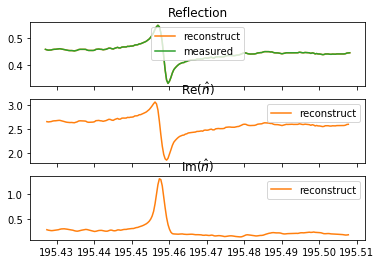

In [23]:
with open('04Oct2018_40.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    omega_data = np.array([])
    r_data = np.array([])    
    t_data = np.array([])    
    for row in reader: 
        omega_data = np.append(omega_data,float(row[0]))
        r_data = np.append(r_data,float(row[1]))
        t_data = np.append(t_data,float(row[2]))
        
d_omega = (omega_data[-1] - omega_data[0])/(len(omega_data)-1)

r_data = r_data/0.8173973894817074*(1.58-1)/(1.58+1)*2

# def running_mean(x, N):
#     cumsum = np.cumsum(np.insert(x, 0, 0)) 
#     return (cumsum[N:] - cumsum[:-N]) / float(N)

# omega_data = running_mean(omega_data,400)
# r_data = running_mean(r_data,400)
# t_data = running_mean(t_data,400)
# omega_data = omega_data[::400]
# r_data = r_data[::400]
# t_data = t_data[::400]


omega_reconstruct = omega_data
omega_L_index = 0
omega_U_index = len(omega_reconstruct)-1

omega_low_reconstruct = omega_reconstruct[omega_L_index]
omega_high_reconstruct = omega_reconstruct[omega_U_index]

r_reconstruct = r_data
theta_reconstruct = np.empty(len(omega_reconstruct))

for i in np.arange(len(omega_reconstruct)):
    theta_reconstruct[i] = theta(omega_reconstruct[i])


n = (1-r_reconstruct**2)/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)
k = (2*r_reconstruct*np.sin(theta_reconstruct))/(1-2*r_reconstruct*np.cos(theta_reconstruct)+r_reconstruct**2)

f, axarr = plt.subplots(3, sharex=True)
axarr[0].set_title('Reflection')
# axarr[0].plot(omega_full, r_data_full, label = 'true', color='C0')
axarr[0].plot(omega_reconstruct, r_reconstruct , label = 'reconstruct', color='C1')
axarr[0].plot(omega_data, r_data , label = 'measured', color='C2')
axarr[0].legend()
axarr[1].set_title('Re($\hat{n}$)')
# axarr[1].plot(omega_full, np.real(n_synthetic_full), label = 'true', color='C0')
axarr[1].plot(omega_reconstruct, n, label = 'reconstruct', color='C1')
axarr[1].legend()
axarr[2].set_title('Im($\hat{n}$)')
# axarr[2].plot(omega_full, np.imag(n_synthetic_full), label = 'true', color='C0')
axarr[2].plot(omega_reconstruct, k, label = 'reconstruct', color='C1')
axarr[2].legend()

# plt.show()

# with open('pretty_data.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',')
#     for i in np.arange(len(n)):
#         writer.writerow([omega_data[i],n[i],k[i],r_data[i],t_data[i]]) 

In [88]:
(1975+2035)/2

2005.0